In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [ ]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, objective, train_epoch, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_loader = DataPreprocessor()
train_df, test_df = data_loader.load_and_preprocess_data("1d")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df['id'].unique())}
input_dim = train_df.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df['mood'].max() + 1

train_df_split, val_df_split = train_test_split(train_df, test_size=0.1, stratify=train_df['id'], random_state=42)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=20)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-17 19:15:39,677] A new study created in memory with name: no-name-f4e1d5e2-73c9-4d9b-94de-f60818350392
[I 2025-04-17 19:15:44,193] Trial 0 finished with value: 0.21426133290538943 and parameters: {'hidden_dim': 56, 'id_embed_dim': 5, 'lr': 0.001023204474195014, 'batch_size': 32, 'alpha': 0.03929485556463661}. Best is trial 0 with value: 0.21426133290538943.
[I 2025-04-17 19:15:44,587] Trial 1 finished with value: 0.5426775042603655 and parameters: {'hidden_dim': 121, 'id_embed_dim': 11, 'lr': 0.0003259330063660973, 'batch_size': 32, 'alpha': 0.12916974573689588}. Best is trial 0 with value: 0.21426133290538943.
[I 2025-04-17 19:15:44,881] Trial 2 finished with value: 0.5682758708310321 and parameters: {'hidden_dim': 105, 'id_embed_dim': 14, 'lr': 0.0002642922289599851, 'batch_size': 32, 'alpha': 0.12295537432621649}. Best is trial 0 with value: 0.21426133290538943.
[I 2025-04-17 19:15:45,184] Trial 3 finished with value: 0.6072791010383668 and parameters: {'hidden_dim': 116,

Best hyperparams: {'hidden_dim': 51, 'id_embed_dim': 6, 'lr': 0.0013284918172954555, 'batch_size': 64, 'alpha': 0.010181413120586597}


In [ ]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [ ]:
for epoch in range(20):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

Epoch 1: train loss = 0.4682, val loss = 0.4324
Epoch 2: train loss = 0.3688, val loss = 0.3145
Epoch 3: train loss = 0.2412, val loss = 0.1932
Epoch 4: train loss = 0.1418, val loss = 0.1191
Epoch 5: train loss = 0.0944, val loss = 0.0870
Epoch 6: train loss = 0.0748, val loss = 0.0729
Epoch 7: train loss = 0.0659, val loss = 0.0659
Epoch 8: train loss = 0.0608, val loss = 0.0626
Epoch 9: train loss = 0.0573, val loss = 0.0590
Epoch 10: train loss = 0.0549, val loss = 0.0571
Epoch 11: train loss = 0.0531, val loss = 0.0554
Epoch 12: train loss = 0.0518, val loss = 0.0550
Epoch 13: train loss = 0.0505, val loss = 0.0533
Epoch 14: train loss = 0.0498, val loss = 0.0519
Epoch 15: train loss = 0.0490, val loss = 0.0521
Epoch 16: train loss = 0.0482, val loss = 0.0513
Epoch 17: train loss = 0.0478, val loss = 0.0516
Epoch 18: train loss = 0.0470, val loss = 0.0509
Epoch 19: train loss = 0.0464, val loss = 0.0511
Epoch 20: train loss = 0.0462, val loss = 0.0506


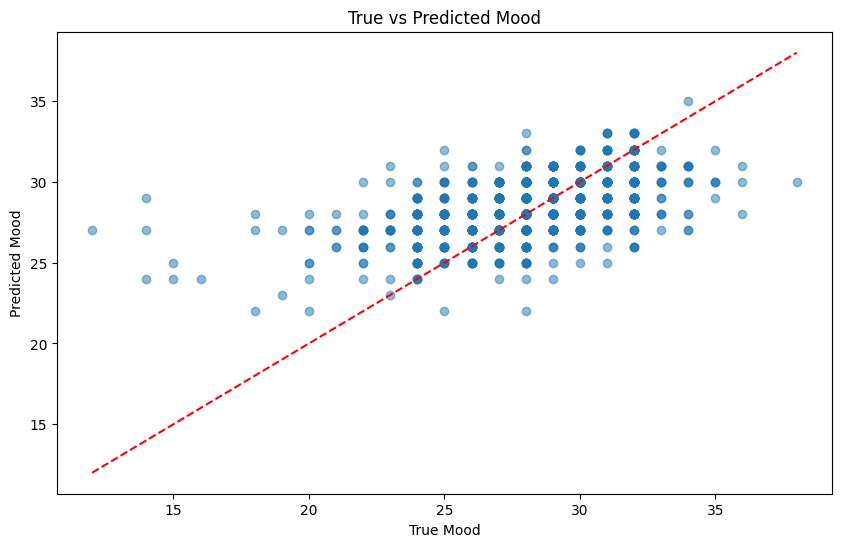

In [ ]:
plot_mood_predictions(model, train_loader, device)

In [ ]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
train_df['mood'].unique(), train_df['mood'].value_counts()

(array([26, 28, 24, 27, 32, 30, 25, 29, 31, 33, 23, 18, 20, 22, 36, 35, 34,
        15, 21, 14, 19, 16, 12, 38], dtype=int32),
 mood
 28    297
 29    138
 32    125
 30    124
 26    103
 27     99
 31     99
 24     68
 25     63
 33     21
 22     17
 23     17
 34     11
 20      7
 35      6
 21      5
 36      4
 18      3
 14      3
 15      2
 19      1
 16      1
 12      1
 38      1
 Name: count, dtype: int64)